# Trajectory modeling / 轨迹分析：距离 vs 速度/加速度

Analyze a single insect's nearest-neighbor distances and kinematics through time（单虫最近邻距离与动力学随时间的关系）。

In [2]:
# Imports & data load（导入与数据读取）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import swarm
from swarm import data, preprocess
from scipy.signal import savgol_filter

plt.style.use("ggplot")

# TODO: set your folder and range（修改数据路径与范围）
data_folder = "D:/3Ddataset/"  # change to your actual path
dfs = data.read_swarm_batch(data_folder, start=16, end=16)
df_raw = data.merge_dict_of_dfs(dfs)

# Optional smoothing with per-id safe windowing（按个体自适应窗口的安全平滑）
def safe_smooth_group(df, cols, window=5, poly=2):
    df2 = df.copy()
    for c in cols:
        def _smooth(x):
            n = len(x)
            # choose the largest odd window <= n（选择不超过轨迹长度的最大奇数窗口）
            w = min(window if window % 2 == 1 else window - 1, n)
            if w < poly + 2 or w < 3:
                return x
            return savgol_filter(x, window_length=w, polyorder=min(poly, w - 1))
        df2[c] = df2.groupby("id")[c].transform(_smooth)
    return df2

df_raw = safe_smooth_group(df_raw, ["x","y","z"], window=5, poly=2)

# Standard preprocessing（中心化+速度/加速度/jerk）
df = preprocess.preprocess_full(df_raw)
df.head()

,id,x,z,y,t,vx,vz,vy,ax,az,ay,source,speed,accel,jx,jy,jz,jerk
0,1,0.000000,0.000000,0.000000,0.06,NaN,NaN,NaN,NaN,NaN,NaN,df16,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-111.046539,-67.381634,-35.692225,0.07,-111.046539,-67.381634,-35.692225,NaN,NaN,NaN,df16,134.705432,NaN,NaN,NaN,NaN,NaN
2,1,-110.085453,-65.768383,-38.333567,0.08,0.961086,1.613251,-2.641342,112.007625,68.994885,33.050883,df16,3.240826,135.640566,NaN,NaN,NaN,NaN
3,1,-108.863749,-64.219794,-41.065164,0.09,1.221703,1.548590,-2.731597,0.260617,-0.064661,-0.090255,df16,3.369319,0.283282,NaN,NaN,NaN,NaN
4,2,-248.147039,61.679435,256.148911,0.07,NaN,NaN,NaN,NaN,NaN,NaN,df16,NaN,NaN,NaN,NaN,NaN,NaN


## Choose target ID and parameters / 选择目标个体与参数

In [3]:
# pick the longest-duration track as target（选择时长最长的轨迹）
track_stats = df.groupby("id")["t"].agg(["min","max","count"])
track_stats["duration"] = track_stats["max"] - track_stats["min"]
target_id = track_stats.sort_values(["duration","count"], ascending=False).index[0]
print(f"Target id (longest duration): {target_id}")

k_neighbors = 5  # for k-nearest neighbor mean distance（近邻数量）

times = np.sort(df["t"].unique())
records = []

Target id (longest duration): 9


## Target track per-variable time series / 目标轨迹单变量时间序列

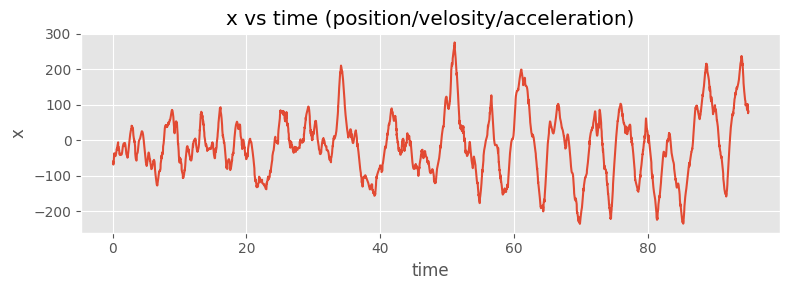

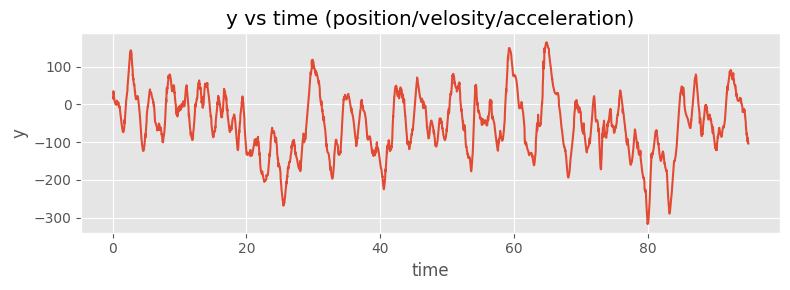

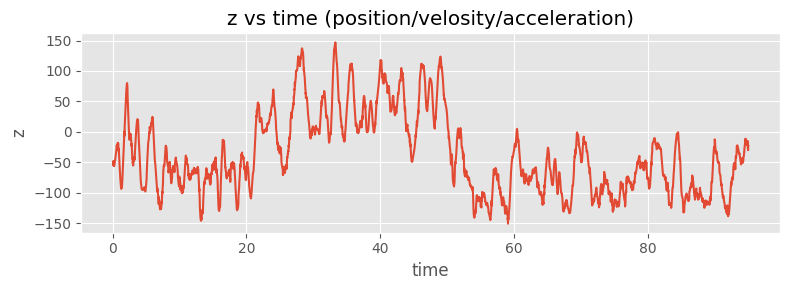

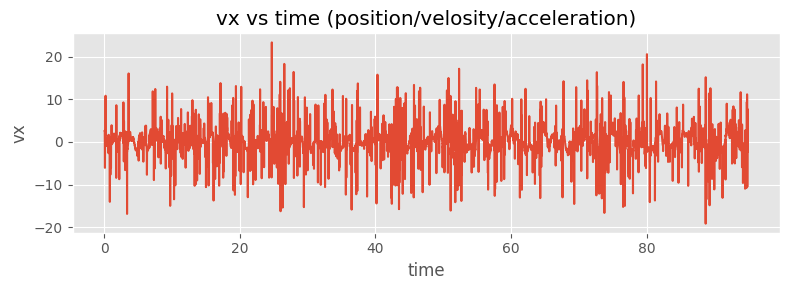

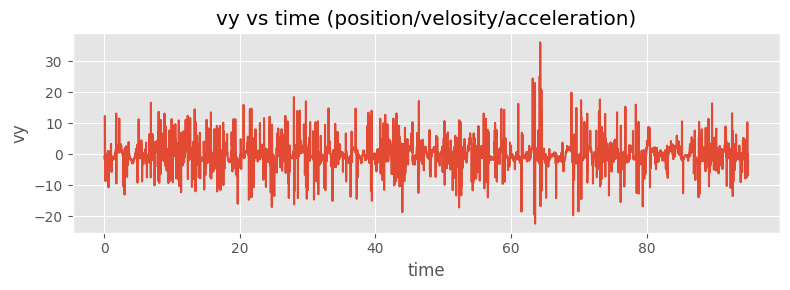

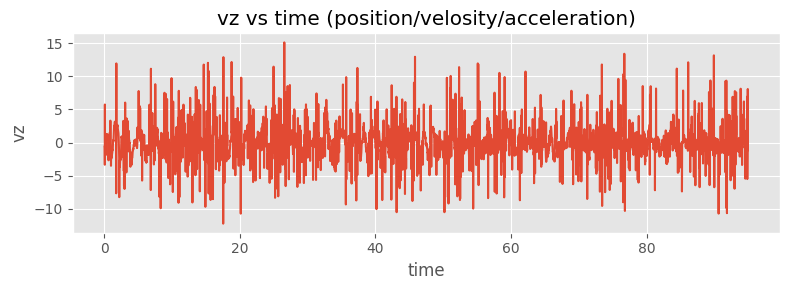

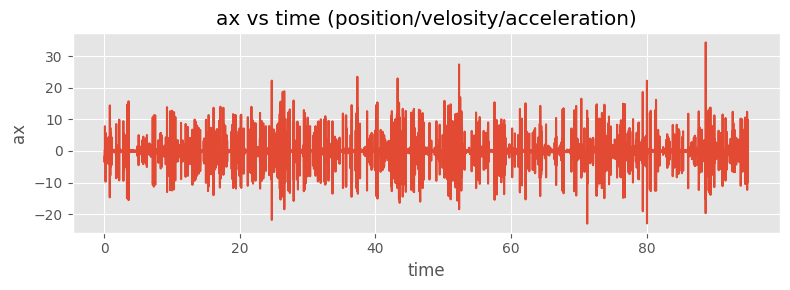

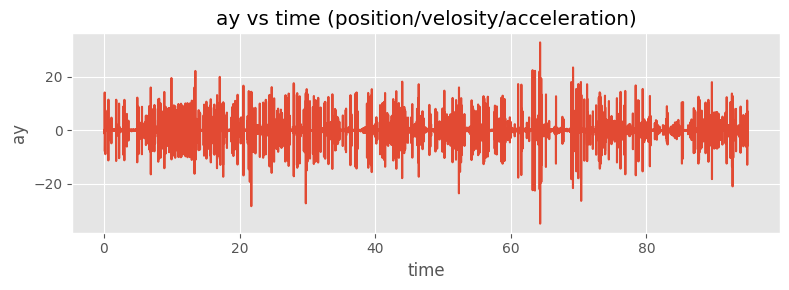

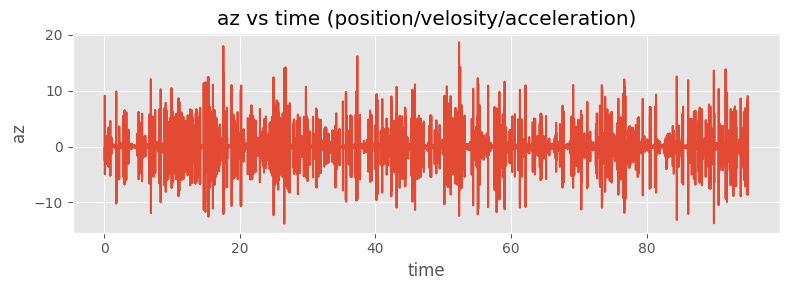

In [4]:
# Extract target track sorted by time（按时间排序的目标轨迹）
track = df[df["id"] == target_id].sort_values("t").copy()

# Plot each physical component separately to reduce clutter（每个物理量单独成图）
cols = ["x","y","z","vx","vy","vz","ax","ay","az"]
for c in cols:
    plt.figure(figsize=(8,3))
    plt.plot(track["t"], track[c])
    plt.xlabel("time")
    plt.ylabel(c)
    plt.title(f"{c} vs time ({'position/velosity/acceleration' if c in ['x','y','z','vx','vy','vz','ax','ay','az'] else ''})")
    plt.tight_layout()
    plt.show()

## Speed magnitude vs time / 速度模随时间

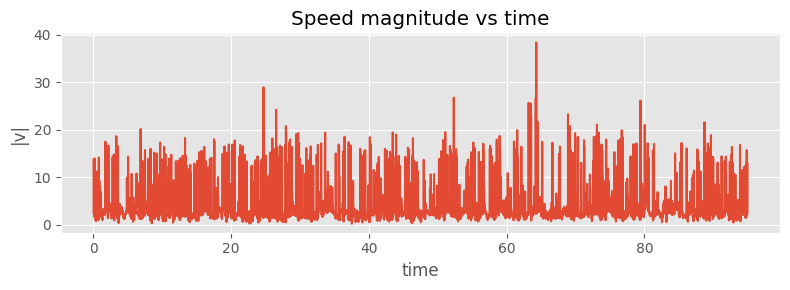

In [5]:
track["speed_mag"] = np.linalg.norm(track[["vx","vy","vz"]].values, axis=1)
plt.figure(figsize=(8,3))
plt.plot(track["t"], track["speed_mag"])
plt.xlabel("time")
plt.ylabel("|v|")
plt.title("Speed magnitude vs time")
plt.tight_layout()
plt.show()

## Acceleration magnitude vs time / 加速度模随时间

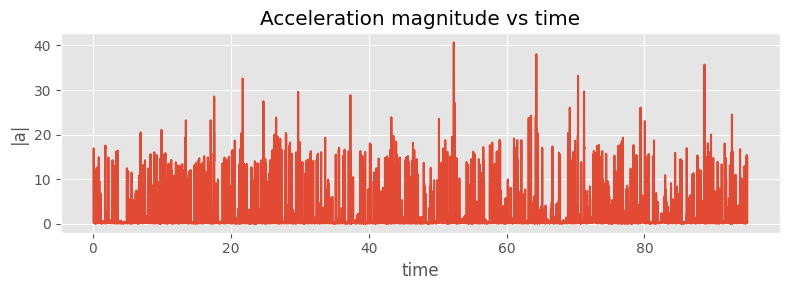

In [6]:
track["accel_mag"] = np.linalg.norm(track[["ax","ay","az"]].values, axis=1)
plt.figure(figsize=(8,3))
plt.plot(track["t"], track["accel_mag"])
plt.xlabel("time")
plt.ylabel("|a|")
plt.title("Acceleration magnitude vs time")
plt.tight_layout()
plt.show()

## Per-frame distances, speed/accel, and alignment / 每帧距离与动力学

In [7]:
for t in times:
    frame = df[df["t"] == t]
    target = frame[frame["id"] == target_id]
    if target.empty or len(frame) <= 1:
        continue

    pos_t = target[["x","y","z"]].values[0]
    vel_t = target[["vx","vy","vz"]].values[0]
    acc_t = target[["ax","ay","az"]].values[0]

    speed = np.linalg.norm(vel_t)
    accel = np.linalg.norm(acc_t)

    others = frame[frame["id"] != target_id]
    if others.empty:
        continue

    dists = np.linalg.norm(others[["x","y","z"]].values - pos_t, axis=1)
    d_nn = dists.min()
    if len(dists) >= k_neighbors:
        d_kmean = np.mean(np.partition(dists, k_neighbors-1)[:k_neighbors])
    else:
        d_kmean = np.mean(dists)

    # alignment with neighbors (mean cosine)
    rel_vel = others[["vx","vy","vz"]].values
    rel_norm = np.linalg.norm(rel_vel, axis=1)
    align = (rel_vel @ vel_t) / ((rel_norm + 1e-9) * (speed + 1e-9))
    align_mean = np.nanmean(align)

    records.append({
        "t": t,
        "d_nn": d_nn,
        "d_kmean": d_kmean,
        "speed": speed,
        "accel": accel,
        "align_mean": align_mean,
        "n_neighbors": len(dists)
    })

traj = pd.DataFrame(records)
traj.head()

C:\Users\Saru\AppData\Local\Temp\ipykernel_16016\1906720872.py:29: RuntimeWarning: Mean of empty slice
  align_mean = np.nanmean(align)


,t,d_nn,d_kmean,speed,accel,align_mean,n_neighbors
0,0.07,61.458520,93.268341,NaN,NaN,NaN,30
1,0.08,58.419794,92.000069,2.745577,NaN,-0.027517,30
2,0.09,55.322396,90.693486,2.807640,0.288416,-0.028619,30
3,0.10,52.080329,103.404884,3.958651,4.548601,0.633700,29
4,0.11,48.884787,101.314583,13.799999,16.908516,0.969879,30


## Time series plots / 时间序列

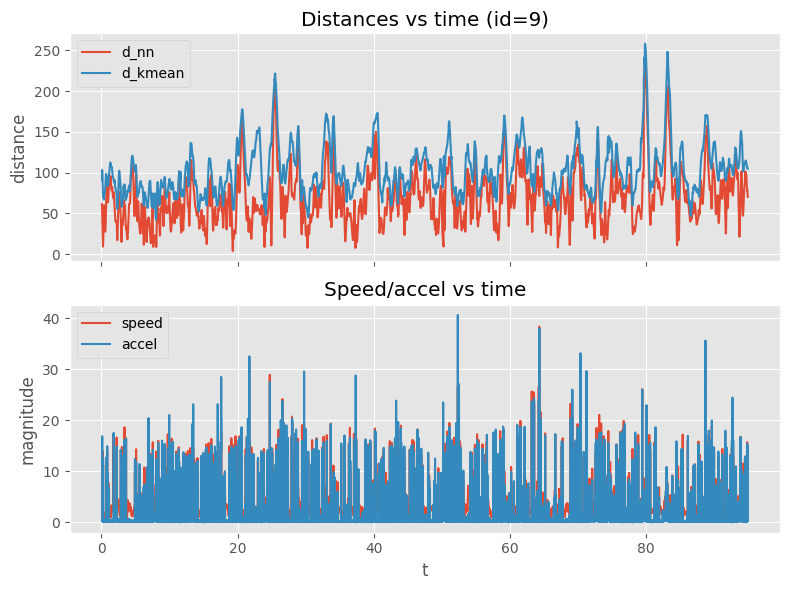

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True)
traj.plot(x="t", y=["d_nn","d_kmean"], ax=axes[0], title=f"Distances vs time (id={target_id})")
traj.plot(x="t", y=["speed","accel"], ax=axes[1], title="Speed/accel vs time")
axes[0].set_ylabel("distance")
axes[1].set_ylabel("magnitude")
plt.tight_layout()
plt.show()

## Scatter relationships / 散点关系

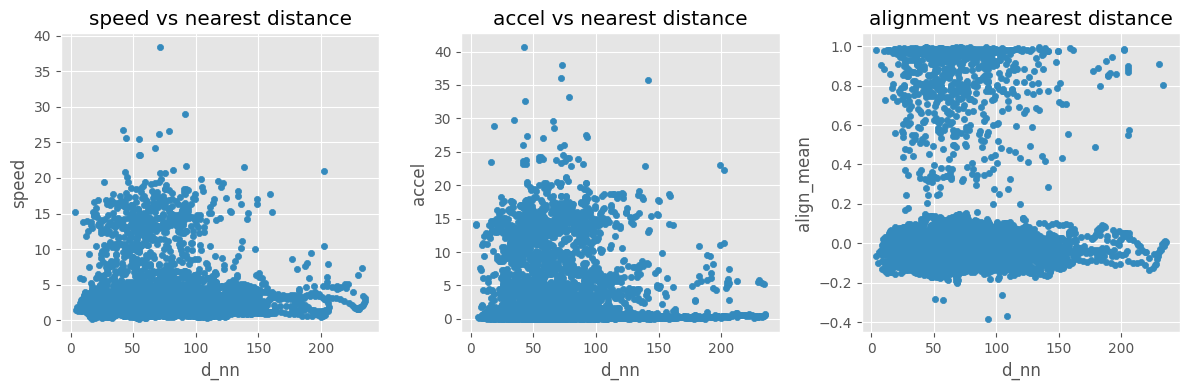

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
traj.plot.scatter(x="d_nn", y="speed", ax=axes[0], title="speed vs nearest distance")
traj.plot.scatter(x="d_nn", y="accel", ax=axes[1], title="accel vs nearest distance")
traj.plot.scatter(x="d_nn", y="align_mean", ax=axes[2], title="alignment vs nearest distance")
plt.tight_layout()
plt.show()

## Neighbor count per frame (optional) / 每帧邻居数量

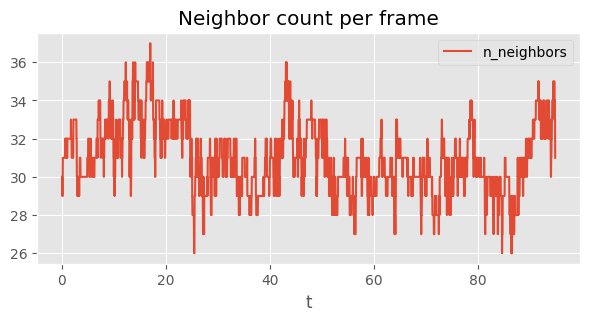

In [10]:
traj.plot(x="t", y="n_neighbors", kind="line", figsize=(7,3), title="Neighbor count per frame")
plt.show()

## Correlation with other individuals / 与其他个体的相关性

In [11]:
# Compute correlations between target and all other individuals（目标与其他个体的相关性）
# We align on common timestamps to ensure overlap（按共同时间对齐）

def compute_correlations(df, target_id, min_overlap=5):
    target = df[df["id"] == target_id].sort_values("t").copy()
    ids = [i for i in df["id"].unique() if i != target_id]
    rows = []
    for oid in ids:
        other = df[df["id"] == oid].sort_values("t")
        merged = pd.merge(
            target[["t","x","y","z","vx","vy","vz"]],
            other[["t","x","y","z","vx","vy","vz"]],
            on="t",
            suffixes=("_t","_o"),
        )
        if len(merged) < min_overlap:
            continue
        # per-component correlations
        corrs = {}
        for comp in ["x","y","z","vx","vy","vz"]:
            corrs[comp] = merged[f"{comp}_t"].corr(merged[f"{comp}_o"])
        merged["speed_t"] = np.linalg.norm(merged[["vx_t","vy_t","vz_t"]].values, axis=1)
        merged["speed_o"] = np.linalg.norm(merged[["vx_o","vy_o","vz_o"]].values, axis=1)
        corrs["speed"] = merged["speed_t"].corr(merged["speed_o"])
        # aggregate score: mean absolute correlation over available components
        vals = [v for v in corrs.values() if pd.notnull(v)]
        if not vals:
            continue
        score = float(np.mean(np.abs(vals)))
        rows.append({"id": oid, "score": score, **corrs, "n_overlap": len(merged)})
    return pd.DataFrame(rows).sort_values("score", ascending=False)

corr_df = compute_correlations(df, target_id, min_overlap=5)
corr_df.head(10)

,id,score,x,y,z,vx,vy,vz,speed,n_overlap
52,60,0.964710,0.967171,0.882622,0.937048,0.987041,0.994989,0.988107,0.995993,6
149,172,0.963954,0.938263,0.979668,0.986056,0.997603,0.929117,0.968405,0.948567,18
296,339,0.960974,0.996431,0.961561,0.969956,0.995194,0.971420,0.836797,0.995460,10
289,332,0.959847,0.999945,-0.993585,-0.997986,0.948940,0.991432,-0.812932,-0.974112,5
301,346,0.959775,0.940573,0.793189,0.998463,0.999335,0.994064,0.993442,0.999357,8
74,86,0.949791,0.993867,-0.991205,-0.988107,0.945587,0.776245,-0.989527,0.963998,5
101,115,0.945008,0.985268,0.950354,-0.867480,0.897445,0.985231,0.935564,0.993716,11
77,90,0.934852,-0.750664,0.993631,-0.910251,0.993457,0.990175,0.914231,0.991554,6
129,149,0.934818,0.912991,0.633302,0.998970,0.999233,0.999992,0.999749,0.999489,5
134,154,0.931071,-0.903626,-0.909274,0.890804,0.974372,0.956943,0.922926,0.959551,68


## Top correlated individuals / 相关性最高的个体

In [12]:
top_n = 2  # number to inspect（要查看的前 N 个个体）

if corr_df.empty:
    print("No sufficient overlap to compute correlations.")
else:
    top_corr = corr_df.head(top_n)
    display(top_corr)
    top_ids = top_corr["id"].tolist()


,id,score,x,y,z,vx,vy,vz,speed,n_overlap
52,60,0.964710,0.967171,0.882622,0.937048,0.987041,0.994989,0.988107,0.995993,6
149,172,0.963954,0.938263,0.979668,0.986056,0.997603,0.929117,0.968405,0.948567,18


## Plot target vs top correlated speeds / 目标与最高相关个体的速度对比

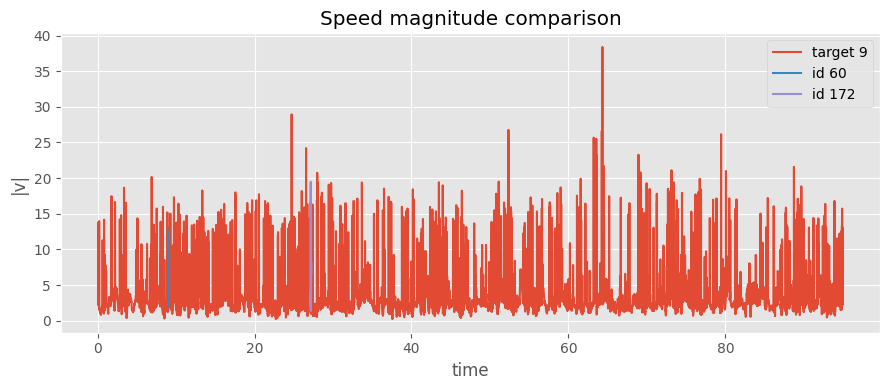

In [13]:
if not corr_df.empty:
    plt.figure(figsize=(9,4))
    plt.plot(track["t"], np.linalg.norm(track[["vx","vy","vz"]].values, axis=1), label=f"target {target_id}")
    for oid in top_ids:
        other = df[df["id"] == oid].sort_values("t")
        plt.plot(other["t"], np.linalg.norm(other[["vx","vy","vz"]].values, axis=1), label=f"id {oid}")
    plt.xlabel("time")
    plt.ylabel("|v|")
    plt.title("Speed magnitude comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Framewise similarity & top partner / 逐帧相似度与最相关个体

In [14]:
# Compute per-frame similarity (velocity cosine) and mean distance（逐帧速度余弦 + 距离的均值）

def framewise_similarity(df, target_id, min_overlap=5):
    target = df[df["id"] == target_id].sort_values("t")
    ids = [i for i in df["id"].unique() if i != target_id]
    rows = []
    for oid in ids:
        other = df[df["id"] == oid].sort_values("t")
        merged = pd.merge(
            target[["t","x","y","z","vx","vy","vz"]],
            other[["t","x","y","z","vx","vy","vz"]],
            on="t",
            suffixes=("_t","_o"),
        )
        n = len(merged)
        if n < min_overlap:
            continue
        # velocity direction cosine per frame
        vt = merged[["vx_t","vy_t","vz_t"]].values
        vo = merged[["vx_o","vy_o","vz_o"]].values
        vt_norm = np.linalg.norm(vt, axis=1)
        vo_norm = np.linalg.norm(vo, axis=1)
        denom = (vt_norm * vo_norm + 1e-9)
        cos = np.sum(vt * vo, axis=1) / denom
        mean_cos = float(np.nanmean(cos))
        # distance per frame
        pt = merged[["x_t","y_t","z_t"]].values
        po = merged[["x_o","y_o","z_o"]].values
        dist = np.linalg.norm(pt - po, axis=1)
        mean_dist = float(np.nanmean(dist))
        rows.append({
            "id": oid,
            "mean_cos": mean_cos,
            "mean_dist": mean_dist,
            "n_overlap": n,
        })
    if not rows:
        return pd.DataFrame()
    return pd.DataFrame(rows).sort_values(["mean_cos","n_overlap"], ascending=[False, False])

sim_df = framewise_similarity(df, target_id, min_overlap=5)
sim_df.head(10)

,id,mean_cos,mean_dist,n_overlap
172,196,0.935353,297.262437,7
407,465,0.927266,263.745126,8
214,242,0.924635,669.618656,14
99,113,0.901163,347.764951,11
439,501,0.880799,331.002312,5
419,478,0.879142,74.752769,6
151,174,0.842459,251.470238,9
330,378,0.829727,725.407143,6
122,141,0.818307,460.467801,5
298,342,0.799878,360.083362,11


## Pick top partner and 3D trajectory plot / 选取最高相似个体并绘制3D轨迹

Top partner by mean velocity cosine: 196.0


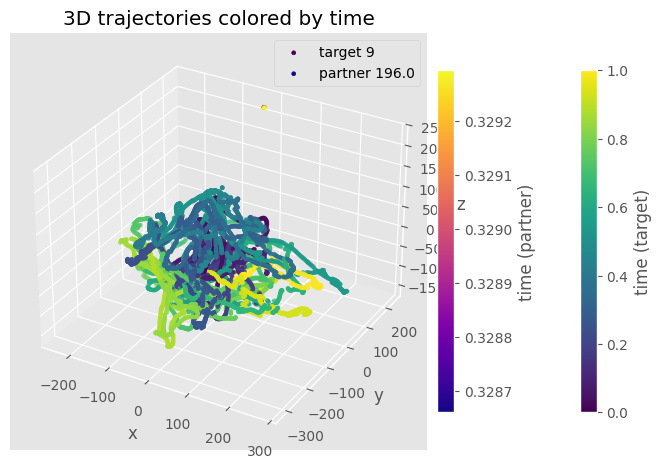

In [18]:
from matplotlib import cm
from matplotlib.colors import Normalize

if sim_df.empty:
    print("No partner with sufficient overlap.")
else:
    top_partner = sim_df.iloc[0]["id"]
    print(f"Top partner by mean velocity cosine: {top_partner}")

    tgt_traj = df[df["id"] == target_id].sort_values("t")
    part_traj = df[df["id"] == top_partner].sort_values("t")

    # Normalize time for coloring
    t_min = min(tgt_traj["t"].min(), part_traj["t"].min())
    t_max = max(tgt_traj["t"].max(), part_traj["t"].max())
    norm = Normalize(vmin=t_min, vmax=t_max)

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')

    sc1 = ax.scatter(tgt_traj["x"], tgt_traj["y"], tgt_traj["z"],
                     c=norm(tgt_traj["t"]), cmap=cm.viridis, s=8, label=f"target {target_id}")
    sc2 = ax.scatter(part_traj["x"], part_traj["y"], part_traj["z"],
                     c=norm(part_traj["t"]), cmap=cm.plasma, s=8, label=f"partner {top_partner}")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title("3D trajectories colored by time")
    fig.colorbar(sc1, ax=ax, shrink=0.6, pad=0.1, label="time (target)")
    fig.colorbar(sc2, ax=ax, shrink=0.6, pad=0.02, label="time (partner)")
    ax.legend()
    plt.tight_layout()
    plt.show()

## Animated GIF (xy projection) / 2D 动画导出

Animating target 9 vs partner 196.0


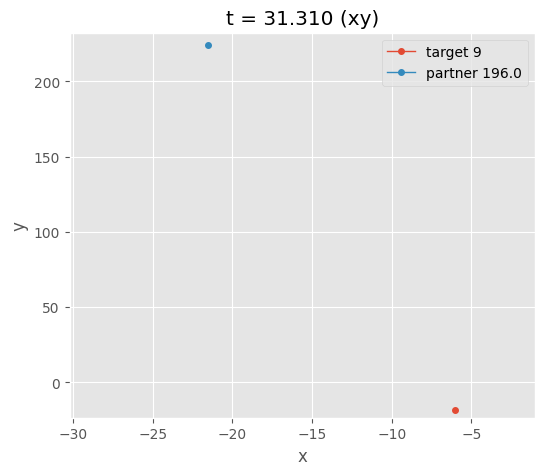

In [17]:
from matplotlib import animation

# Ensure we have a partner from the similarity table
if sim_df.empty:
    raise RuntimeError("No partner with sufficient overlap to animate.")

partner_id = sim_df.iloc[0]["id"]
print(f"Animating target {target_id} vs partner {partner_id}")

# Align on common timestamps
traj_tgt = df[df["id"] == target_id].sort_values("t")
traj_prt = df[df["id"] == partner_id].sort_values("t")
common_t = np.intersect1d(traj_tgt["t"].unique(), traj_prt["t"].unique())
traj_tgt = traj_tgt[traj_tgt["t"].isin(common_t)]
traj_prt = traj_prt[traj_prt["t"].isin(common_t)]

fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"2D trajectory animation (xy) target {target_id} vs {partner_id}")
line1, = ax.plot([], [], 'o-', lw=1, ms=4, label=f"target {target_id}")
line2, = ax.plot([], [], 'o-', lw=1, ms=4, label=f"partner {partner_id}")
ax.legend()

# Set limits based on both trajectories for consistent view
x_all = np.concatenate([traj_tgt["x"].values, traj_prt["x"].values])
y_all = np.concatenate([traj_tgt["y"].values, traj_prt["y"].values])
ax.set_xlim(x_all.min()-5, x_all.max()+5)
ax.set_ylim(y_all.min()-5, y_all.max()+5)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

def animate(i):
    t = common_t[i]
    tt = traj_tgt[traj_tgt["t"] == t]
    pp = traj_prt[traj_prt["t"] == t]
    line1.set_data(tt["x"], tt["y"])
    line2.set_data(pp["x"], pp["y"])
    ax.set_title(f"t = {t:.3f} (xy)")
    return line1, line2

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(common_t), interval=100, blit=True)

# Save to GIF (requires Pillow)
ani.save("traj_xy.gif", writer="pillow", fps=10)
plt.show()